<center><img src="img/logo_hse.png" width="1000"></center>

<h1><center>Прикладные задачи анализа данных</center></h1>
<h2><center>Домашнее задание 1: Генеративные сети</center></h2>

# Введение

Не все же нам MNIST генерировать. Давайте посмотрим, как генеративные модели могут использоваться не только для развлечения. Поехали!

Немного вступления и мотивации, для чего мы хотим обучать модель.

## MAGIC – Major Atmospheric Gamma Imaging Cherenkov Telescope

MAGIC (Major Atmospheric Gamma Imaging Cherenkov) - это система, состоящая из двух черенковских телескопов диаметром 17 м. Они предназначены для наблюдения гамма-лучей от галактических и внегалактических источников в диапазоне очень высоких энергий (от 30 ГэВ до 100 ТэВ). 

MAGIC позволил открыть и исследовать новые классы источников гамма-излучения, таких как, например, пульсары и гамма-всплески (GRB).

<center><img src="img/magic1.jpg" width="1000"></center>

Источник: https://magic.mpp.mpg.de/

Youtube video: https://youtu.be/mjcDSR2vSU8

#### Ок, давайте зафиксируем. Какой-то крутой телескоп позволяет открыть новые виды излучения. Идем дальше.

## Частицы из космоса

Космические частицы, $\gamma$-кванты (фотоны) и адроны (протоны), взаимодействуют с атмосферой и порождают ливни вторичных частиц. Двигаясь с околосветовой скоростью, эти частицы излучают Черенковское излучение. Телескопы фотографируют это излучение. 
#### По фотографиям можно определить тип частицы из космоса: фотон или протон. Знакомая формулировка задачи, не правда ли?

<center><img src="img/shower.jpg" width="500"></center>

## Фотографии

Задача атмосферного черенковского телескопа - получить изображение ливня путем измерения черенковского света от частиц ливня. Это изображение представляет собой геометрическую проекцию ливня на детектор. Для анализа этих изображений были введены параметры изображения или так называемые параметры Хилласа. Ниже пример такой фотографии.

<center><img src="img/geo.jpg" width="400"></center>

#### Итак, каждая фотография описывается набором параметров, которые за нас считает телесоп. А что там с двумя видами частиц?

## Фотоны vs адронов

Изображения для $\gamma$-квантов (фотонов) и адронов (протонов) отличаются по форме кластеров. Астрономы используют модели машинного обучения для классификации этих изображений. Получение каждого такого изображения - дорогое удовольствие!


<center><img src="img/gamma_p.png" width="600"></center>

Для обучения моделей ученые искусственно генерируют такие изображения для каждого типа частиц с помощью сложных физических симуляторов. 

#### Итак, давайте сэкономим денег для ученых и сгенерируем хороших фотографий разных частиц. Используем для этого GAN и диффузионные модели!

In [222]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Данные

Будем использовать данные телескопа MAGIC из UCI репозитория https://archive.ics.uci.edu/ml/datasets/MAGIC+Gamma+Telescope. Каждый объект в данных - параметры одного изображения кластера и метка этого кластера (фотон или адрон):


0. Length: major axis of ellipse [mm]
1. Width: minor axis of ellipse [mm]
2. Size: 10-log of sum of content of all pixels [in #phot]
3. Conc: ratio of sum of two highest pixels over fSize [ratio]
4. Conc1: ratio of highest pixel over fSize [ratio]
5. Asym: distance from highest pixel to center, projected onto major axis [mm]
6. M3Long: 3rd root of third moment along major axis [mm]
7. M3Trans: 3rd root of third moment along minor axis [mm]
8. Alpha: angle of major axis with vector to origin [deg]
9. Dist: distance from origin to center of ellipse [mm]
10. class: g,h # gamma (signal), hadron (background)

In [223]:
# read data
names = np.array(
    [
        "Length",
        "Width",
        "Size",
        "Conc",
        "Conc1",
        "Asym",
        "M3Long",
        "M3Trans",
        "Alpha",
        "Dist",
        "class",
    ]
)
data = pd.read_csv("data/magic04.data", header=None)
data.columns = names
print(data.shape)
data.head()

(19020, 11)


,Length,Width,Size,Conc,Conc1,Asym,M3Long,M3Trans,Alpha,Dist,class
0,28.7967,16.0021,2.6449,0.3918,0.1982,27.7004,22.0110,-8.2027,40.0920,81.8828,g
1,31.6036,11.7235,2.5185,0.5303,0.3773,26.2722,23.8238,-9.9574,6.3609,205.2610,g
2,162.0520,136.0310,4.0612,0.0374,0.0187,116.7410,-64.8580,-45.2160,76.9600,256.7880,g
3,23.8172,9.5728,2.3385,0.6147,0.3922,27.2107,-6.4633,-7.1513,10.4490,116.7370,g
4,75.1362,30.9205,3.1611,0.3168,0.1832,-5.5277,28.5525,21.8393,4.6480,356.4620,g


# Постановка задачи

Ваша задача заключается в том, чтобы с помощью генеративно-состязательных сетей научиться генерировать параметры кластеров на изображениях телескопа для каждого типа частиц (фотона или адрона):

- $X$ - матрица реальных объектов, которые нужно начиться генерировать;
- $y$ - метки классов, которые будем использовать как условие при генерации.

In [224]:
# параметры кластеров на изображениях
X = data[names[:-1]].values
X = np.abs(X)

# метки классов
labels = data[names[-1]].values
y = np.ones((len(labels), 1))
y[labels == "h"] = 0

In [225]:
# примеры
X[:2]

array([[2.87967e+01, 1.60021e+01, 2.64490e+00, 3.91800e-01, 1.98200e-01,
        2.77004e+01, 2.20110e+01, 8.20270e+00, 4.00920e+01, 8.18828e+01],
       [3.16036e+01, 1.17235e+01, 2.51850e+00, 5.30300e-01, 3.77300e-01,
        2.62722e+01, 2.38238e+01, 9.95740e+00, 6.36090e+00, 2.05261e+02]])

In [226]:
# примеры
y[:10]

array([[1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.]])

In [227]:
# все возможные значения
np.unique(y)

array([0., 1.])

# Визуализация данных

Каждое изображение описывается 10 параметрами. Давайте построим распределения значений каждого параметра для каждого типа частиц.

In [228]:
def plot_hists(X1, X2, names, label1, label2, bins=np.linspace(-3, 3, 61)):
    plt.figure(figsize=(5 * 4, 5 * 2))
    for i in range(X1.shape[1]):
        plt.subplot(3, 4, i + 1)
        plt.grid()
        plt.hist(X1[:, i], bins=bins, alpha=0.3, label=label1, color="C4")
        plt.hist(X2[:, i], bins=bins, alpha=0.3, label=label2, color="C0")
        plt.xlabel(names[i], size=14)
        plt.legend(loc="best")
    plt.tight_layout()

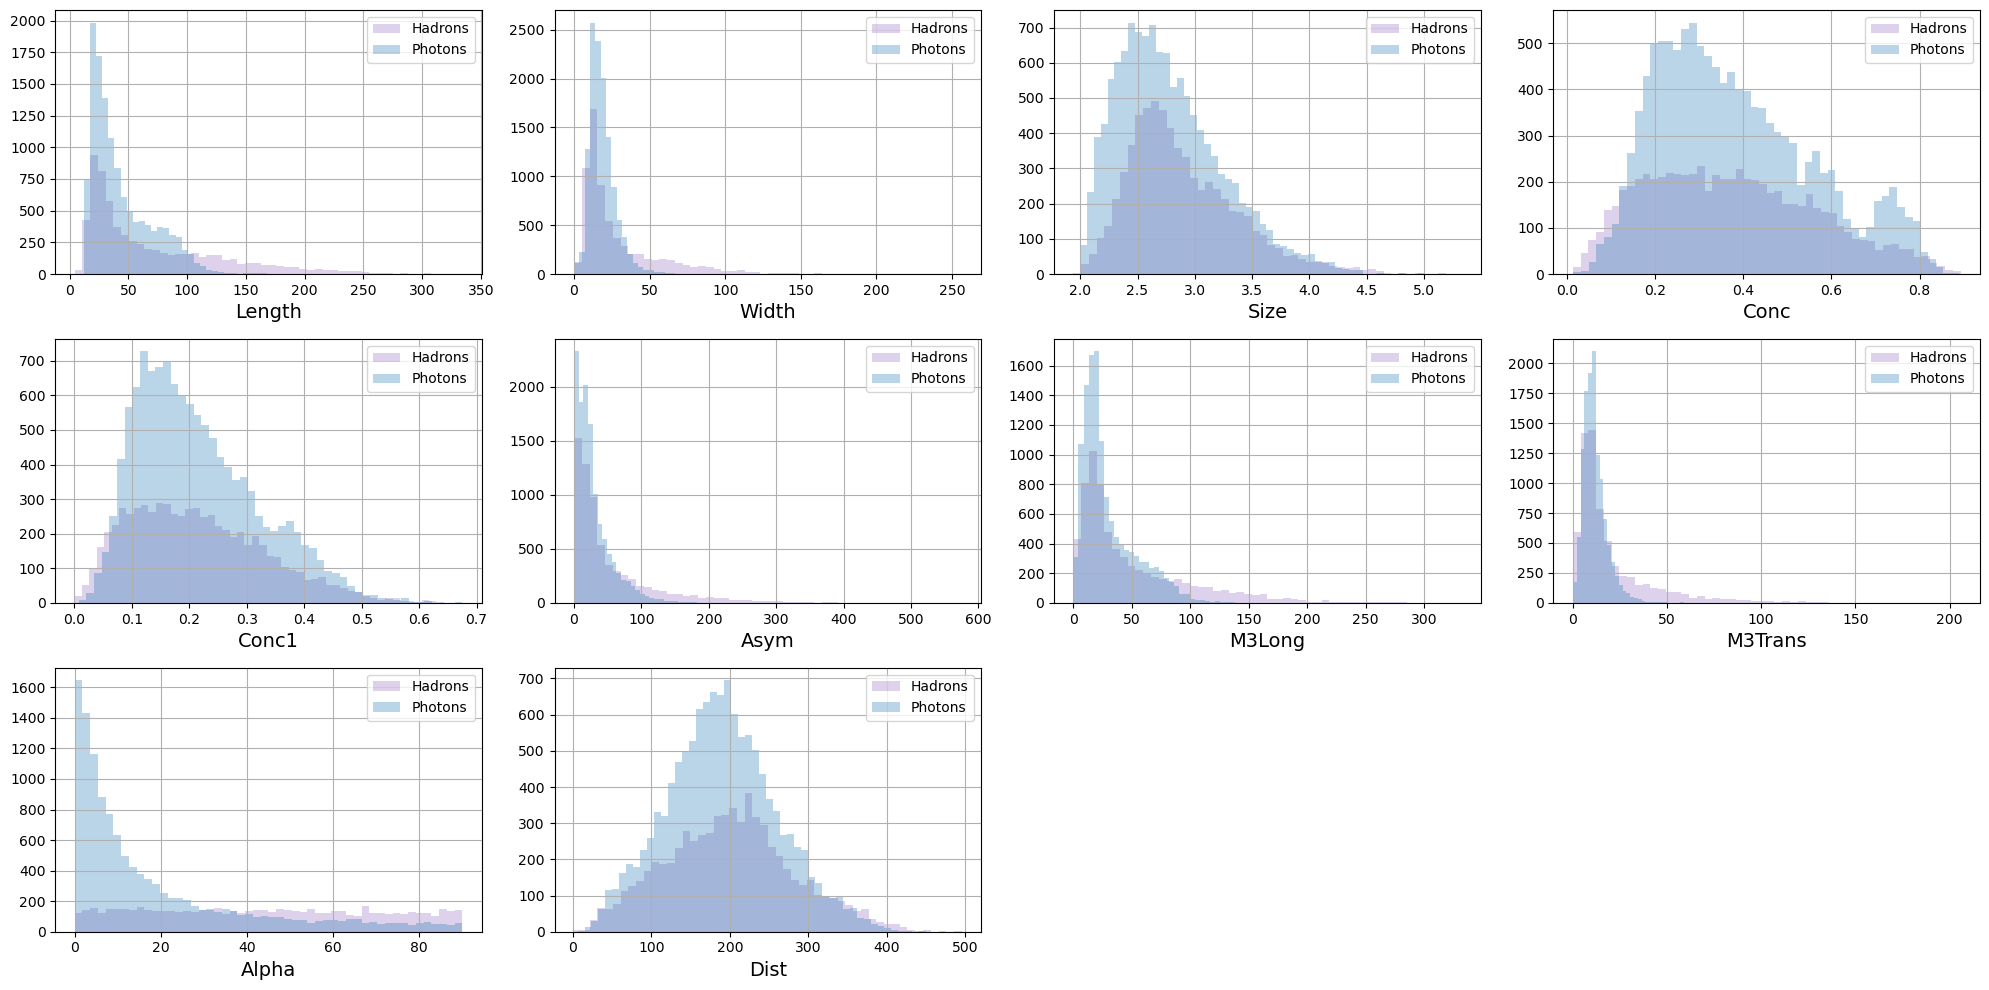

In [229]:
plot_hists(
    X[y[:, 0] == 0], X[y[:, 0] == 1], names, label1="Hadrons", label2="Photons", bins=50
)

# Предобработка данных

Из графика видим, что распределения для многих признаков имеют тяжелые хвосты. Это делает обучение генеративных моделей тяжелее. Поэтому нужно как-то преобразовать данные, чтобы убрать эти тяжелые хвосты.

# Обучающая и тестовая выборки

In [230]:
from sklearn.model_selection import train_test_split

# train / test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify = y, test_size=0.5, shuffle = True, random_state = 11
)

## Задание 1 (0.2 балла)

Проиллюстрируйте распределение y внутри train и test выборки.

Text(0.5, 1.0, 'test')

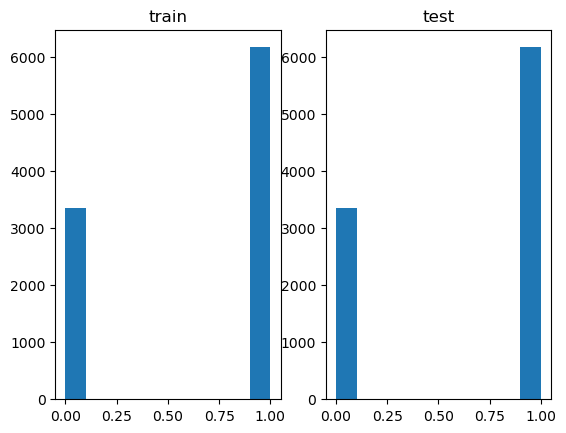

In [231]:
fid, ax = plt.subplots(1,2)
ax[0].hist(y_train)
ax[0].set_title("train")
ax[1].hist(y_test)
ax[1].set_title("test")

## Задание 2 (0.8 балл)

Используя функцию `sklearn.preprocessing.QuantileTransformer` трансформируйте входные данные `X_train` и `X_test`. Это преобразование делает так, чтобы распределение каждого параметра было нормальным. Описание функции доступно по [ссылке](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.QuantileTransformer.html). Используйте значение параметра `output_distribution='normal'`.

In [232]:
### YOUR CODE IS HERE ######
from sklearn.preprocessing import QuantileTransformer
qt = QuantileTransformer(output_distribution='normal')

X_train = qt.fit_transform(X_train)
X_test = qt.transform(X_test)
### THE END OF YOUR CODE ###

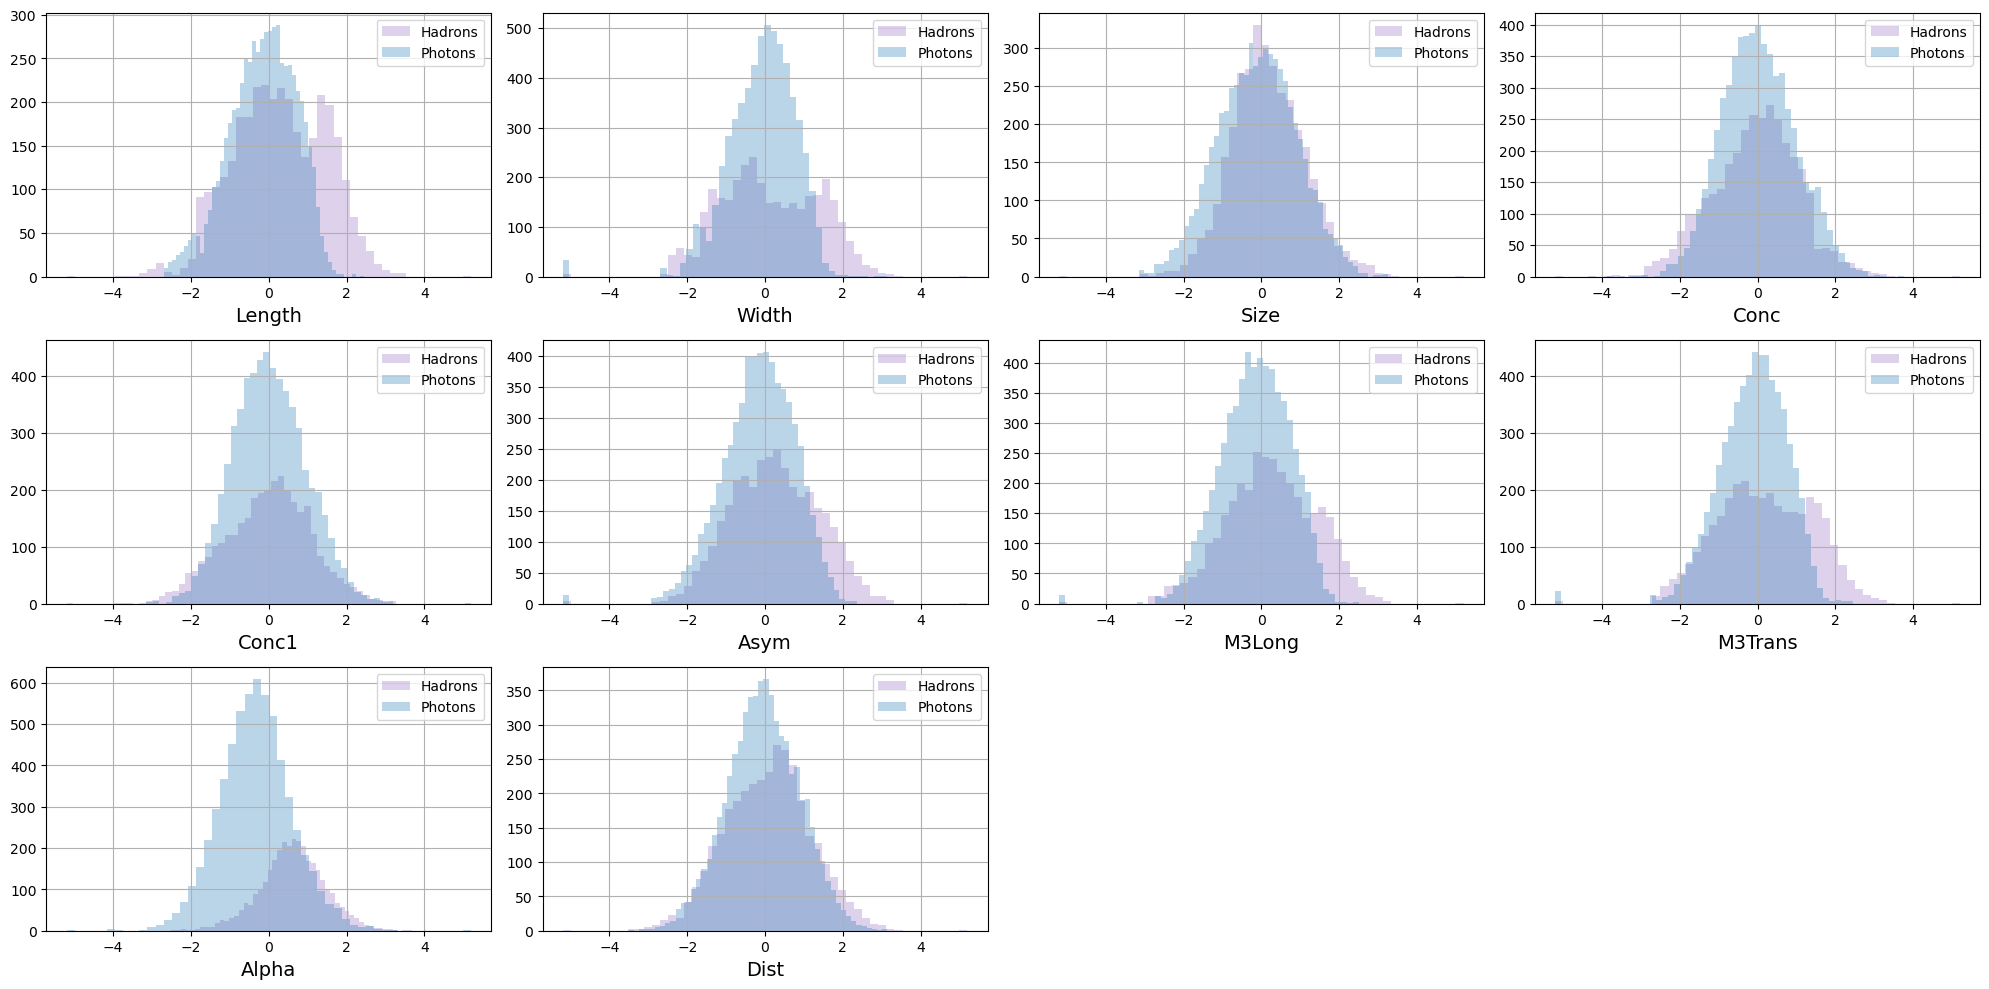

In [233]:
plot_hists(
    X_train[y_train[:, 0] == 0],
    X_train[y_train[:, 0] == 1],
    names,
    label1="Hadrons",
    label2="Photons",
    bins=50,
)

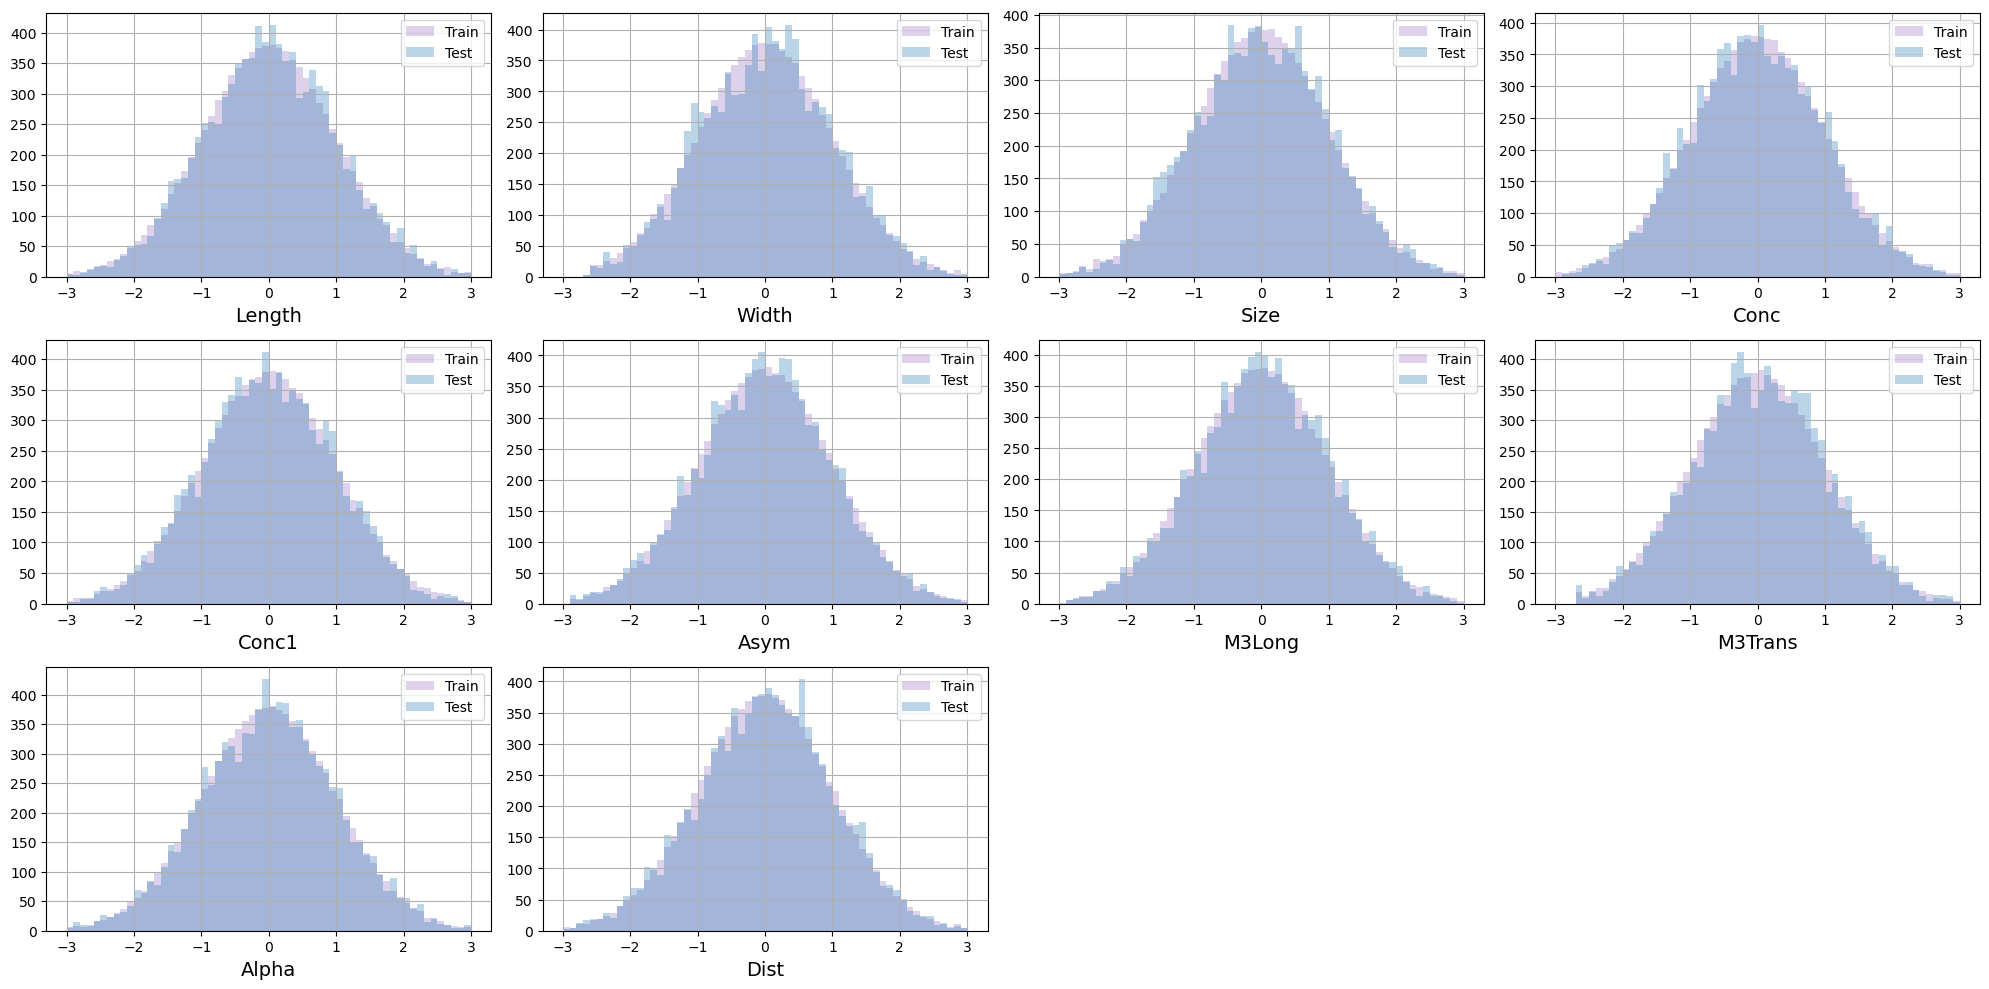

In [234]:
plot_hists(X_train, X_test, names, label1="Train", label2="Test")

# Conditional WGAN

Мы будем использовать `Conditional WGAN`, который изображен на рисунке. В качестве условия `y` мы будем использовать метку класса: **0** - адрон, **1** - фотон. Таким образом, мы будем сообщать генератору для какой частицы нужно генерировать параметры изображения. 

<center><img src="img/cgan.png" width="800"></center>

Генератор $\hat{x} = G(z, y)$ будет принимать на вход шумовой вектор $z$ и вектор условий $y$, а выдавать будет сгенерированный (фейковый) вектор параметров $\hat{x}$. 

Дискриминатор $D(x, y)$ будет принимать на вход вектор параметров $x$ и вектор условий $y$, а возвращать будет рациональное число.

Обучать `Conditional WGAN` будем с такой функцией потерь:

$$L(G, D) = -\frac{1}{n} \sum_{x_i \in X, y_i \in y} D(x_i, y_i) + -\frac{1}{n} \sum_{z_i \in Z, y_i \in y} D(G(z_i, y_i), y_i) \to \max_G \min_D$$

In [235]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset

DEVICE = torch.device("cpu")

In [236]:
DEVICE

device(type='cpu')

## Задание 3 (0.75 балла)

Реализуйте нейронную сеть для генератора со следующими слоями:
- Полносвязный слой со 100 нейронами;
- Слой батч-нормализации;
- ReLU функцию активации;
- Полносвязный слой со 100 нейронами;
- Слой батч-нормализации;
- ReLU функцию активации;
- Выходной слой.

In [237]:
class Generator(nn.Module):
    def __init__(self, n_inputs, n_outputs):
        super(Generator, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(n_inputs, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(),
            nn.Linear(100, n_outputs),
        )
        ### YOUR CODE IS HERE ######
        
        ### THE END OF YOUR CODE ###

    def forward(self, z, y):
        zy = torch.cat((z, y), dim=1)
        return self.net(zy)

## Задание 4 (0.5 балл)

Реализуйте функцию для генерации новый объектов $X$ по вектору условий $y$.

In [238]:
def generate(generator, y, latent_dim):
    z = torch.randn(y.shape[0], latent_dim, dtype=torch.float32)
    y = torch.tensor(y, dtype=torch.float32)
    #print(type(z),"\n", type(y))
    X_fake = generator(z, y)
    #print(type(X_fake))
    ### THE END OF YOUR CODE ###
    return X_fake  # numpy

## Задание 5 (0.75 балла)

Реализуйте нейронную сеть для дискриминатора со следующими слоями:
- Полносвязный слой со 100 нейронами;
- ReLU функцию активации;
- Полносвязный слой со 100 нейронами;
- ReLU функцию активации;
- Выходной слой.

Какая функция активации должна быть в конце работы модели и почему? А она вообще тут должна быть? Обоснуйте свой выбор.

In [239]:
class Discriminator(nn.Module):
    def __init__(self, n_inputs):
        super(Discriminator, self).__init__()
        self.net = nn.Sequential(
        nn.Linear(n_inputs, 100),
        nn.ReLU(),
        nn.Linear(100, 100),
        nn.ReLU(),
        nn.Linear(100,1),
        nn.Sigmoid(), # Нам нужна вероятность принадлежности к реальному объекту,
                   )           # поэтому используем сигмоид в конце.

    def forward(self, x, y):
        xy = torch.cat((x, y), dim=1)
        return self.net(xy)

## Задание 6 (0.5 балла)

Реализуйте функцию, которая принимала бы на вход набор сгенерированных и настоящих объектов, разбивала на train и test с учетом баланса классов (real и fake объектов), с соотношением 3 к 1, обучала модель линейной регрессии и градиентного бустинга, которые учились бы отличать настоящие объекты от фальшивых, после чего выводила бы accuracy score на отложенной выборке у обоих моделей.

Ответьте на вопрос: какое значение accuracy score нас бы удовлетворило больше всего? Почему?

In [240]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
#accuracy в идеале должна стремиться к 0.5 
#т.к. классы распределены 50/50 и мы real относим к real
# и fake мы относим к real. То есть угадываем половину  


In [241]:
def other_agent_score(X_real, y_real, X_fake, y_fake):
    #т.к. нам нужна бинарная классификация будем использовать LogisticRegression и GradientBoostingClassifier
    X_rf = torch.cat((X_real, X_real)) 
    y_rf = torch.cat((y_real, y_fake))
    X_rf = torch.tensor(X_rf, dtype=torch.float32)
    y_rf = torch.tensor(y_rf, dtype=torch.float32)

    X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(X_rf, y_rf,stratify = y_rf, 
                                                                    test_size=0.33, shuffle = True, random_state = 11 )
    gbr = GradientBoostingClassifier()
    gbr.fit(X_train_rf,y_train_rf)
    lr = LogisticRegression()
    lr.fit(X_train_rf,y_train_rf)
    pred =torch.tensor(lr.predict(X_test_rf), dtype=torch.bool)
    #pred.view(660,1)
    y_test_rf = torch.tensor(y_test_rf, dtype=torch.bool)
    lin_reg_score = accuracy_score(y_test_rf, pred)

    
    pred = torch.tensor(gbr.predict(X_test_rf), dtype=torch.bool)
    boosting_score = accuracy_score(y_test_rf, pred)
    ### THE END OF YOUR CODE ###
    print('Linear regression score: ' + str(lin_reg_score))
    print('Boosting score: ' + str(boosting_score))

## Задание 7 (1.5 балла)

Реализуйте класс для обучения генеративной модели.

- Подсказка 1: не забывайте ограничивать веса дискриминатора. Для этого используйте `p.data.clamp_(-0.01, 0.01)`, где `p` веса дискриминатора.
- Подсказка 2: `n_critic` - число итераций обучения дискриминатора на одну итерацию обучения генератора.
- Подсказка 3: Используйте `X_tensor = torch.tensor(X_numpy, dtype=torch.float, device=DEVICE)` для перевода numpy в тензор.

In [242]:
from random import randint

In [243]:
n = randint(0, 8000)
X_val = torch.cat((torch.tensor(X_train[1:10]),torch.Tensor(X_train[30:200])))
X_val.shape

torch.Size([179, 10])

In [244]:
class Fitter(object):
    def __init__(
        self,
        generator,
        discriminator,
        batch_size = 32,
        n_epochs = 10,
        latent_dim = 1,
        lr = 0.0001,
        n_critic=5,
    ):

        self.generator = generator
        self.discriminator = discriminator
        self.batch_size = batch_size
        self.n_epochs = n_epochs
        self.latent_dim = latent_dim
        self.lr = lr
        self.n_critic = n_critic

        self.opt_gen = torch.optim.RMSprop(self.generator.parameters(), lr=self.lr)
        self.opt_disc = torch.optim.RMSprop(self.discriminator.parameters(), lr=self.lr)

        self.generator.to(DEVICE)
        self.discriminator.to(DEVICE)

    def fit(self, X, y):

        # numpy to tensor
        X_real = torch.tensor(X, dtype=torch.float, device=DEVICE)
        y_cond = torch.tensor(y, dtype=torch.float, device=DEVICE)

        # tensor to dataset
        dataset_real = TensorDataset(X_real, y_cond)

        # Turn on training
        self.generator.train(True)
        self.discriminator.train(True)

        self.loss_history = []

        # Fit GAN
        for epoch in range(self.n_epochs):
            for i, (real_batch, cond_batch) in enumerate(
                DataLoader(dataset_real, batch_size=self.batch_size, shuffle=True)
            ):

                ### YOUR CODE IS HERE ######
                real_obj_score = self.discriminator(real_batch, cond_batch)
                X_gen = generate(self.generator, cond_batch, self.latent_dim)
                
                gen_obj_scores = self.discriminator(X_gen, cond_batch)
                if (i % self.n_critic == 4):
                    self.opt_gen.zero_grad()
                    gen_loss = torch.mean(gen_obj_scores)
                    gen_loss.backward()
                    self.opt_gen.step()
                else:
                    self.opt_disc.zero_grad()
                    disc_loss =  torch.mean(real_obj_score) - torch.mean(gen_obj_scores)
                    disc_loss.backward()
                    self.opt_disc.step()

                ### THE END OF YOUR CODE ###

            # caiculate and store loss after an epoch
            Z_noise = torch.normal(0, 1, (len(X_real), self.latent_dim))
            X_fake = self.generator(Z_noise, y_cond)
            loss_epoch = torch.mean(self.discriminator(X_real, y_cond)) - torch.mean(
                self.discriminator(X_fake, y_cond)
            )
            self.loss_history.append(loss_epoch.detach().cpu())
            
            # Создайте выборку из 1000 объектов из X_train и 1000 сгенерированных объектов 
            # И запустите работу фукнции other_agent_score
            
            ### YOUR CODE IS HERE ######
            n = randint(0, 8000)
            Xy_val = torch.cat((torch.tensor(X_train[n:n+1000]),torch.Tensor(y_train[n:n+1000])),  dim=1)
            y_val = torch.ones(1000,1)
            Xy_fake = generate(self.generator, y_train[n:n+1000], self.latent_dim)
            y_val_f = torch.zeros(1000,1)
            other_agent_score(Xy_val, y_val, Xy_fake, y_val_f)
            ### THE END OF YOUR CODE ###
            
        # Turn off training
        self.generator.train(False)
        self.discriminator.train(False)

## Обучение
Обучим модель на данных.

In [245]:
import warnings

warnings.filterwarnings('ignore')

In [246]:
#%%time
latent_dim = 10
generator = Generator(n_inputs=latent_dim + y.shape[1], n_outputs=X_train.shape[1])
discriminator = Discriminator(n_inputs=X_train.shape[1] + y.shape[1])

fitter = Fitter(
    generator,
    discriminator,
    batch_size=50,
    n_epochs=117,
    latent_dim=latent_dim,
    lr=0.0001,
    n_critic=5,
)
fitter.fit(X_train, y_train)

Linear regression score: 0.47424242424242424
Boosting score: 0.22575757575757577
Linear regression score: 0.4666666666666667
Boosting score: 0.24545454545454545
Linear regression score: 0.4666666666666667
Boosting score: 0.21515151515151515
Linear regression score: 0.47424242424242424
Boosting score: 0.22272727272727272
Linear regression score: 0.45606060606060606
Boosting score: 0.23484848484848486
Linear regression score: 0.45
Boosting score: 0.21818181818181817
Linear regression score: 0.46515151515151515
Boosting score: 0.23787878787878788
Linear regression score: 0.4575757575757576
Boosting score: 0.22575757575757577
Linear regression score: 0.49393939393939396
Boosting score: 0.23787878787878788
Linear regression score: 0.45454545454545453
Boosting score: 0.2287878787878788
Linear regression score: 0.4484848484848485
Boosting score: 0.2318181818181818
Linear regression score: 0.4863636363636364
Boosting score: 0.22727272727272727
Linear regression score: 0.45454545454545453
Boost

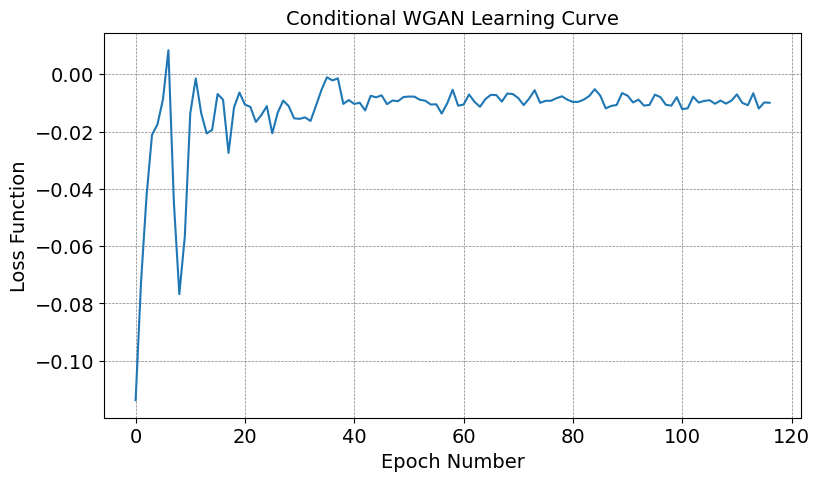

In [247]:
# WGAN learning curve
plt.figure(figsize=(9, 5))
plt.plot(fitter.loss_history)
plt.xlabel("Epoch Number", size=14)
plt.ylabel("Loss Function", size=14)
plt.xticks(size=14)
plt.yticks(size=14)
plt.title("Conditional WGAN Learning Curve", size=14)
plt.grid(b=1, linestyle="--", linewidth=0.5, color="0.5")
plt.show()

Теперь сгенерируем фейковые матрицы `X_fake_train` и `X_fake_test`. Сравним их с матрицами реальных объектов `X_train` и `X_test`. Перед сравнением результатов сделайте обратное квантильное преобразование с помощью трансформера, который вы обучили в задании 2.

In [248]:
### YOUR CODE IS HERE ######

### THE END OF YOUR CODE ###

In [249]:
X_fake_train = generate(fitter.generator, y_train, latent_dim)
X_fake_train = X_fake_train.detach().numpy()
X_fake_train = qt.inverse_transform(X_fake_train)
X_train_wo_qt = qt.inverse_transform(X_train)

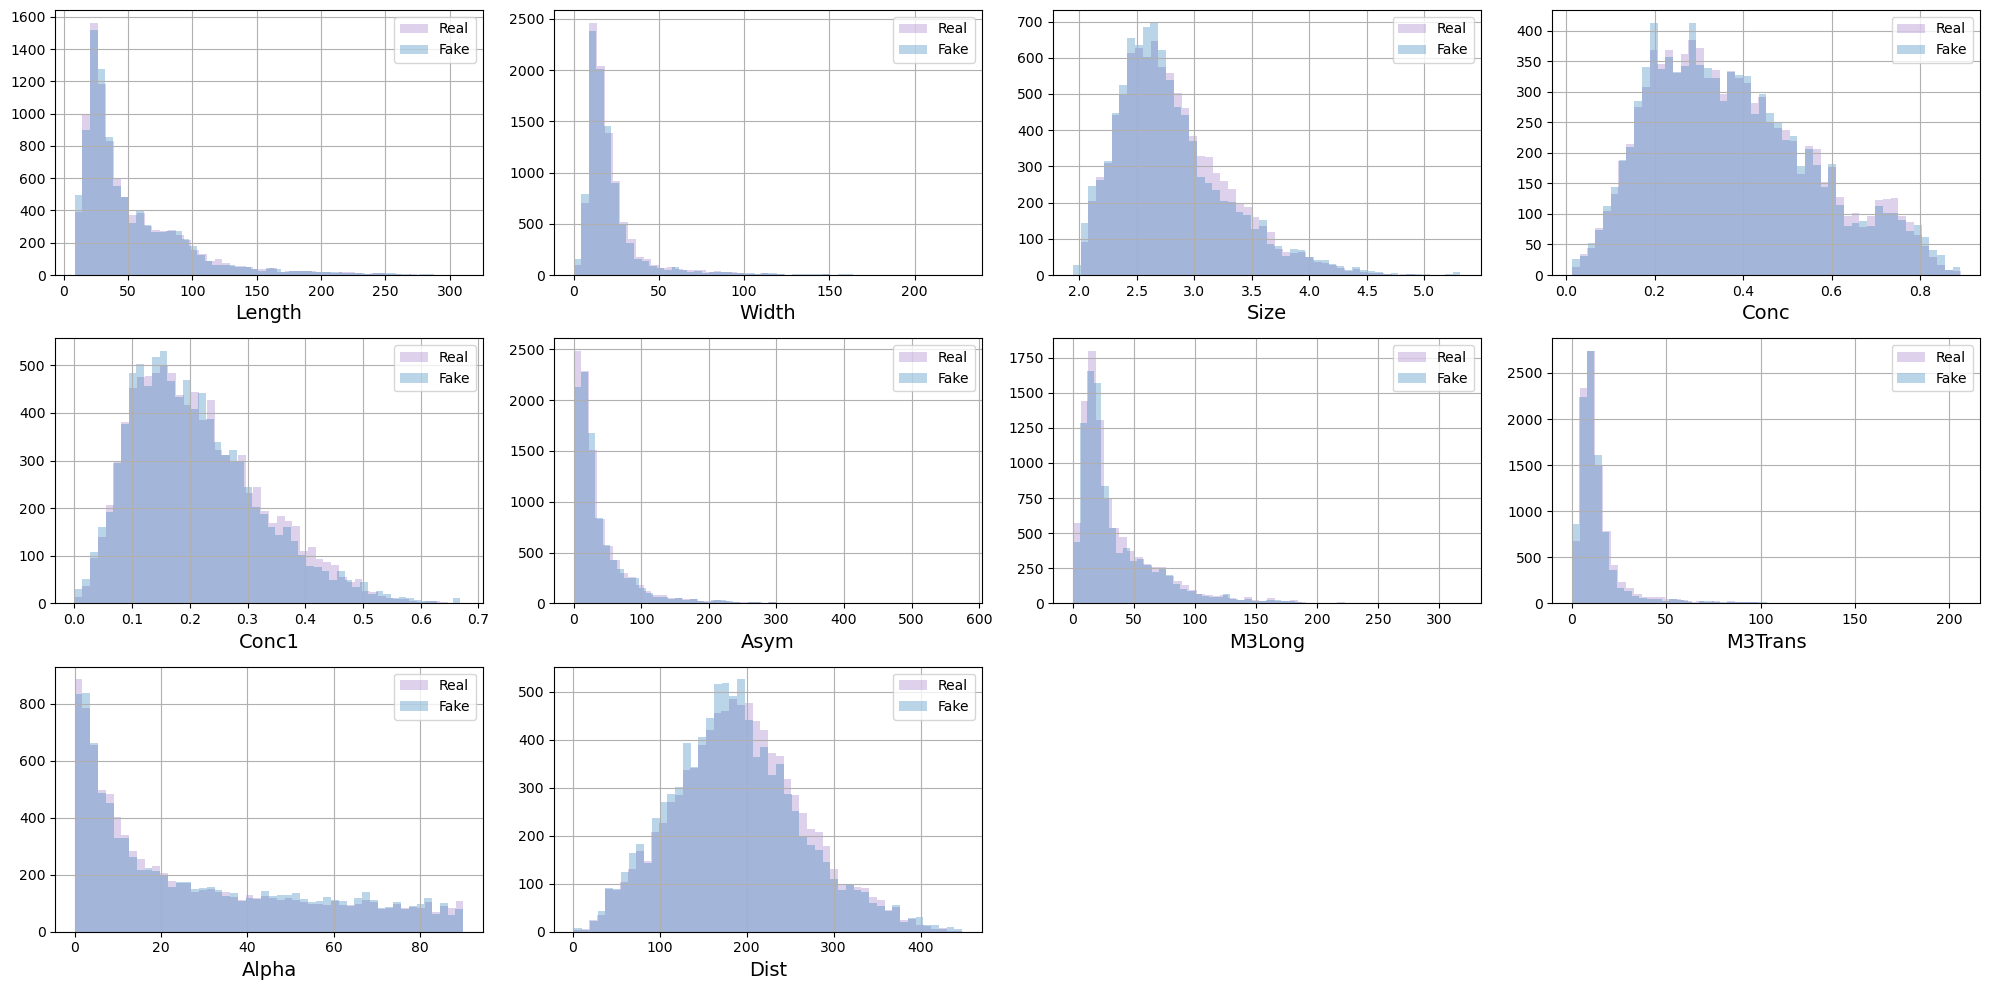

In [250]:
plot_hists(X_train_wo_qt, X_fake_train, names, label1="Real", label2="Fake", bins=50)

In [251]:
X_fake_test = generate(fitter.generator, y_test, latent_dim)
X_fake_test = X_fake_test.detach().numpy()
X_fake_test = qt.inverse_transform(X_fake_test)
X_test_wo_qt = qt.inverse_transform(X_test)


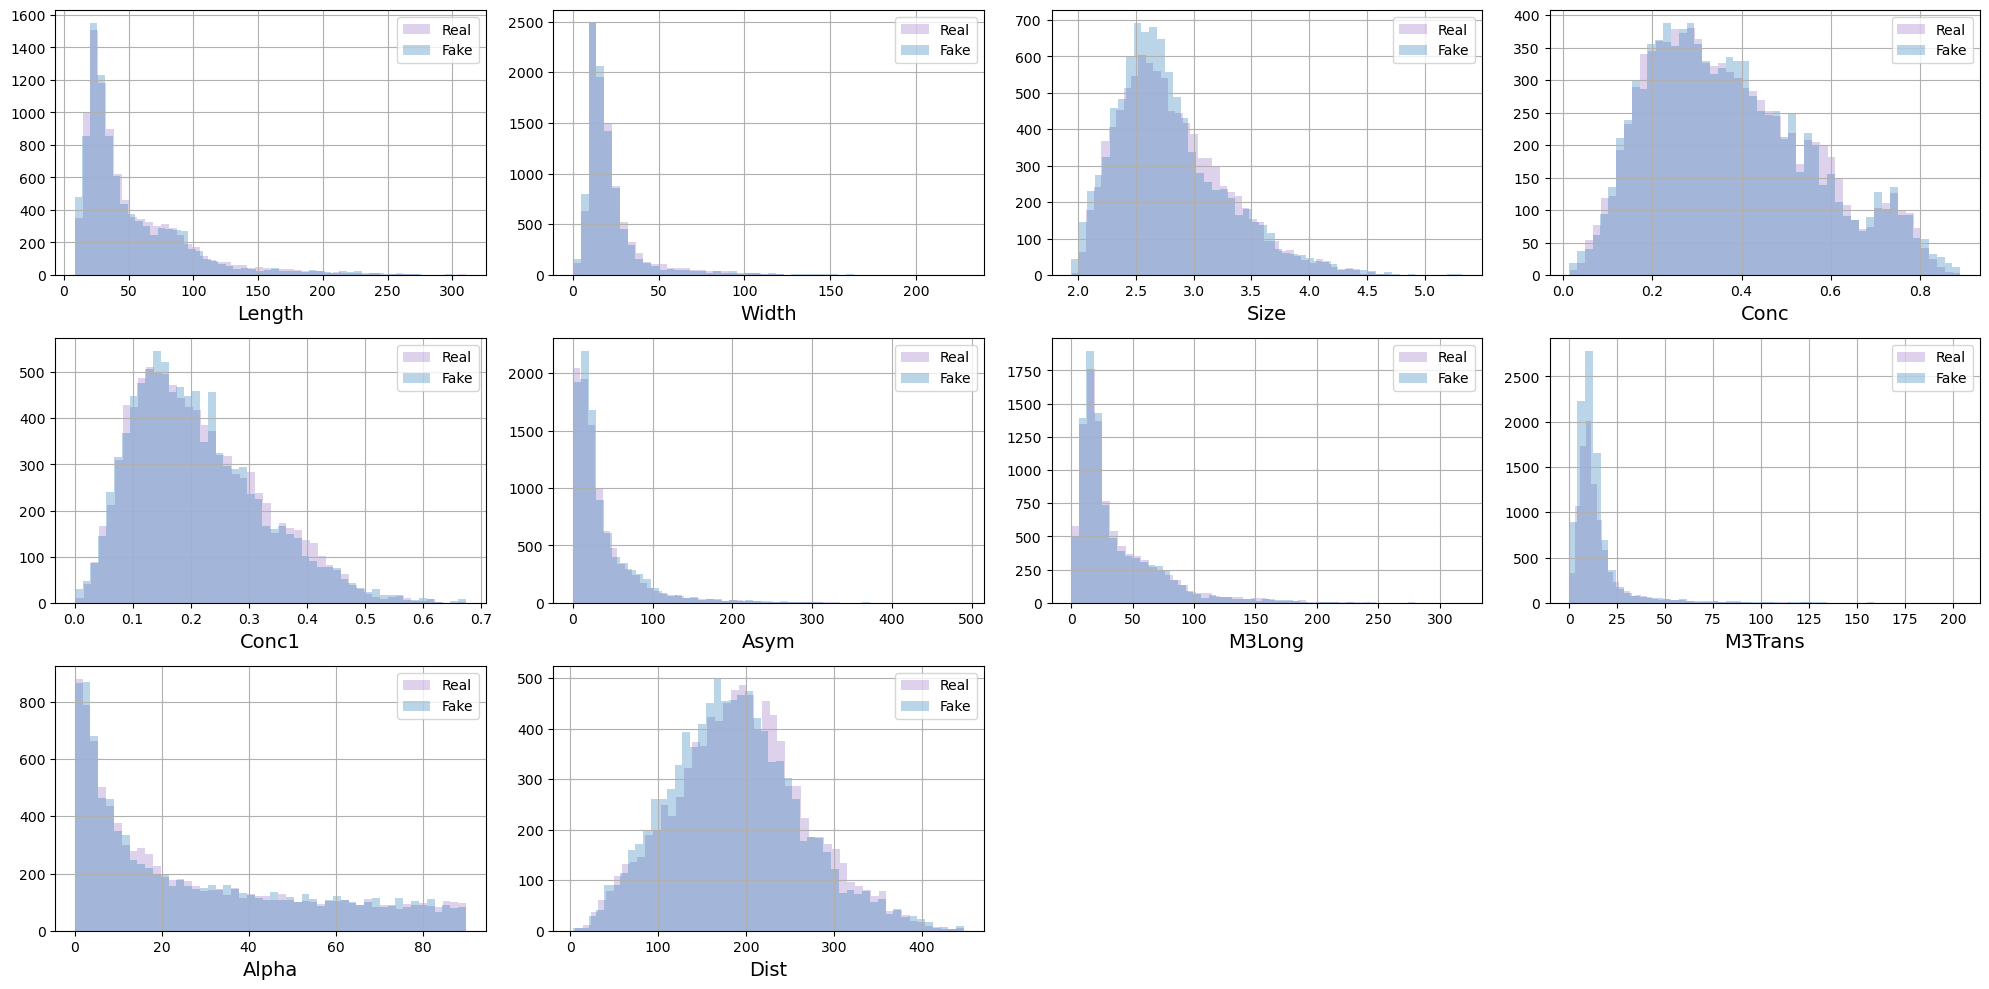

In [252]:
plot_hists(X_test_wo_qt, X_fake_test, names, label1="Real", label2="Fake", bins=50)

## Вывод: 
Визуально мы видим сходство реальных и фейковых данных. Однако это только проекции 10-мерных объектов на одну ось.

# Измерение качества генерации

<center><img src="img/clf.png" width="600"></center>

Измерим сходство распределений классификатором.

In [253]:
# собираем реальный и фейковые матрицы в одну
# поменял X_train на X_train_wo_qt т.к. на предыдущем шаге создал дополнительные переменные
# для обратного преобразования. 
XX_train = np.concatenate((X_fake_train, X_train_wo_qt), axis=0)
XX_test = np.concatenate((X_fake_test, X_test_wo_qt), axis=0)

yy_train = np.array([0] * len(X_fake_train) + [1] * len(X_train_wo_qt))
yy_test = np.array([0] * len(X_fake_test) + [1] * len(X_test_wo_qt))

In [254]:
from sklearn.ensemble import GradientBoostingClassifier

# обучаем классификатор
clf = GradientBoostingClassifier()
clf.fit(XX_train, yy_train)

# получаем прогнозы
yy_test_proba = clf.predict_proba(XX_test)[:, 1]

In [255]:
from sklearn.metrics import roc_auc_score

auc = roc_auc_score(yy_test, yy_test_proba)
print("ROC AUC = ", auc)

ROC AUC =  0.6844540972422631


## Задание 9 (0.5 балла)

Опишите ваш эксперимент. Как вы оцениваете полученные результаты? Как вы думаете, какое значение ROC AUC нас удовлетворяет больше всего? Почему?


## ОПИСАНИЕ РЕЗУЛЬТАТОВ
Roc auc = 0.68 я считаю хорошим результатом, т.к. для дискриминатора и генераторы использовались простые архитектуры + судя по графиком выше, распределения для fake и true сильно похожи. В идеале получить значение Roc auc, стремящееся к 0.5, в таком случае алгоритм не может отличить fake от true.

## Диффузионные модели.

Давайте теперь проведем такой же экперимент с простой диффузионной моделью.

## Задание 10 (0.5 балла)

Реализуйте фукнцию из семинара для зашумления данных, адаптировав ее под наш тип данных.

In [256]:
def corrupt(x, amount):
    ### YOUR CODE IS HERE ######
    noise = torch.randn_like(x) 
    amount = amount.view(-1, 1, 1, 1)
    
    ### THE END OF YOUR CODE ###
    return x

In [257]:
from diffusers import DDPMScheduler

## Добавим sсheduler, он пригодится вам при обучении модели

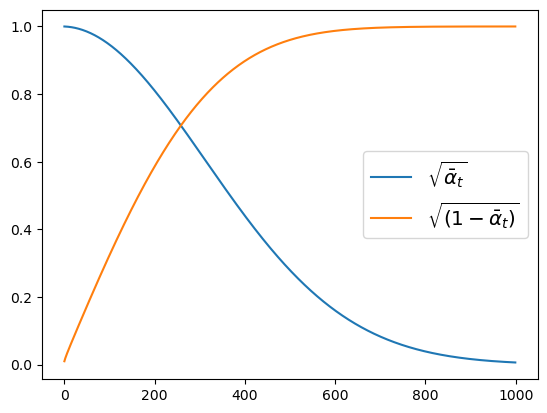

In [258]:
noise_scheduler = DDPMScheduler(num_train_timesteps=1000)
plt.plot(noise_scheduler.alphas_cumprod.cpu() ** 0.5, label=r"${\sqrt{\bar{\alpha}_t}}$")
plt.plot((1 - noise_scheduler.alphas_cumprod.cpu()) ** 0.5, label=r"$\sqrt{(1 - \bar{\alpha}_t)}$")
plt.legend(fontsize="x-large")

## Задание 11 (0.5 балла)

Реализуйте нейронную сеть. В качетсве архитектуры можете взять модель генератора. В процессе экспериментов попробуйте изменять архитектуру модели для улучшения качества сгенерированных объектов (Кстати, как вы будете качество измерять?). 

- Полносвязный слой со 100 нейронами;
- Слой батч-нормализации;
- ReLU функцию активации;
- Полносвязный слой со 100 нейронами;
- Слой батч-нормализации;
- ReLU функцию активации;
- Выходной слой.

In [259]:
class DiffusionGenerator(nn.Module):
    def __init__(self, n_inputs, n_outputs):
        super(DiffusionGenerator, self).__init__()

        ### YOUR CODE IS HERE ######
        self.net = nn.Sequential(
            nn.Linear(n_inputs, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(),
            nn.Linear(100,100),
            nn.BatchNorm1d(100),
            nn.ReLU(),
            nn.Linear(100,200),
            nn.BatchNorm1d(200),
            nn.ReLU(),
            nn.Linear(200, n_outputs),
        )
        ### THE END OF YOUR CODE ###

    def forward(self, z, y):
        zy = torch.cat((z, y), dim=1)
        return self.net(zy)

## Задание 12 (0.5 балла)

Напишите функцию для генерации нового объекта с помощью обученной модели.

In [260]:
def generate_with_diffusion(model, y, latent_dim, sheduler):
    ### YOUR CODE IS HERE ######
    z = torch.randn(y.shape[0], latent_dim, dtype=torch.float32)
    y = torch.tensor(y, dtype=torch.float32)

        
    residual = model(z, y)  

    # Update sample with step
    x = noise_scheduler.step(residual, 3, z).prev_sample

    
    ### THE END OF YOUR CODE ###
    return x  # numpy

## Задание 13 (2 балла)

Напишите класс обучения диффузионной модели и обучите модель, после чего опишите полученные результаты. В качестве подсказки - опирайтесь на семинар по диффузионным моделям. Вы можете изменять некоторые части кода для вашего удобства, но оставляйте в таком случаи комментарии, пожалуйста.

In [261]:
class DiffusionFitter(object):
    def __init__(
        self,
        model,
        batch_size = 32,
        n_epochs = 10,
        latent_dim = 1,
        lr = 0.0001,
        n_critic=5,
    ):

        self.model = generator
        self.batch_size = batch_size
        self.n_epochs = n_epochs
        self.latent_dim = latent_dim
        self.lr = lr
        self.n_critic = n_critic

        self.opt_gen = torch.optim.RMSprop(self.model.parameters(), lr=self.lr)

        self.model.to(DEVICE)

    def fit(self, X, y):

        # numpy to tensor
        X_real = torch.tensor(X, dtype=torch.float, device=DEVICE)
        y_cond = torch.tensor(y, dtype=torch.float, device=DEVICE)

        # tensor to dataset
        dataset_real = TensorDataset(X_real, y_cond)

        # Turn on training
        self.model.train(True)

        self.loss_history = []
        self.loss_fn = nn.MSELoss()
        # Fit GAN
        for epoch in range(self.n_epochs):
            loss_epoch = 0
            for i, (real_batch, cond_batch) in enumerate(
                DataLoader(dataset_real, batch_size=self.batch_size, shuffle=True)
            ):

                

                noise = torch.randn_like(real_batch)
                timesteps = torch.randint(0, 999, (real_batch.shape[0],)).long().to(DEVICE)
                noisy_x = noise_scheduler.add_noise(real_batch, noise, timesteps)
                


                #print(noisy_x)
                pred = self.model(noisy_x, cond_batch)
                
                #print(pred)
                #print(real_batch)

                loss = self.loss_fn(pred, noise)

                self.opt_gen.zero_grad()
                loss.backward()
                self.opt_gen.step()
                #print(loss)
                
                loss_epoch += loss
                
                ### THE END OF YOUR CODE ###

            # caiculate and store loss after an epoch
            
            self.loss_history.append(loss_epoch)

            # Создайте выборку из 1000 объектов из X_train и 1000 сгенерированных объектов 
            # И запустите работу фукнции other_agent_score
            
            ### YOUR CODE IS HERE ######
            n = randint(0, 8000)
            Xy_val = torch.cat((torch.tensor(X_train[n:n+1000]),torch.Tensor(y_train[n:n+1000])),  dim=1)
            y_val = torch.ones(1000,1)
            Xy_fake = generate_with_diffusion(self.model, y_train[n:n+1000], self.latent_dim, noise_scheduler)
            y_val_f = torch.zeros(1000,1)
            other_agent_score(Xy_val, y_val, Xy_fake, y_val_f)
            ### THE END OF YOUR CODE ###
            
        # Turn off training
        self.model.train(False)

In [262]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify = y, test_size=0.5, shuffle = True, random_state = 11
)

In [263]:
from sklearn.preprocessing import QuantileTransformer
qt = QuantileTransformer(output_distribution='normal')

X_train = qt.fit_transform(X_train)
X_test = qt.transform(X_test)

In [264]:
#%%time
latent_dim = 10
model = DiffusionGenerator(n_inputs=latent_dim + y.shape[1], n_outputs=X_train.shape[1])

diffusionFitter = DiffusionFitter(
    model,
    batch_size=50,
    n_epochs=200,
    latent_dim=latent_dim,
    lr=0.0001,
    n_critic=5,
)
diffusionFitter.fit(X_train, y_train)

Linear regression score: 0.4909090909090909
Boosting score: 0.2196969696969697
Linear regression score: 0.4727272727272727
Boosting score: 0.23030303030303031
Linear regression score: 0.4575757575757576
Boosting score: 0.2318181818181818
Linear regression score: 0.4636363636363636
Boosting score: 0.22727272727272727
Linear regression score: 0.4590909090909091
Boosting score: 0.22272727272727272
Linear regression score: 0.46060606060606063
Boosting score: 0.2287878787878788
Linear regression score: 0.4590909090909091
Boosting score: 0.21363636363636362
Linear regression score: 0.4696969696969697
Boosting score: 0.21666666666666667
Linear regression score: 0.453030303030303
Boosting score: 0.23030303030303031
Linear regression score: 0.44242424242424244
Boosting score: 0.2196969696969697
Linear regression score: 0.44242424242424244
Boosting score: 0.21363636363636362
Linear regression score: 0.46060606060606063
Boosting score: 0.22121212121212122
Linear regression score: 0.45454545454545

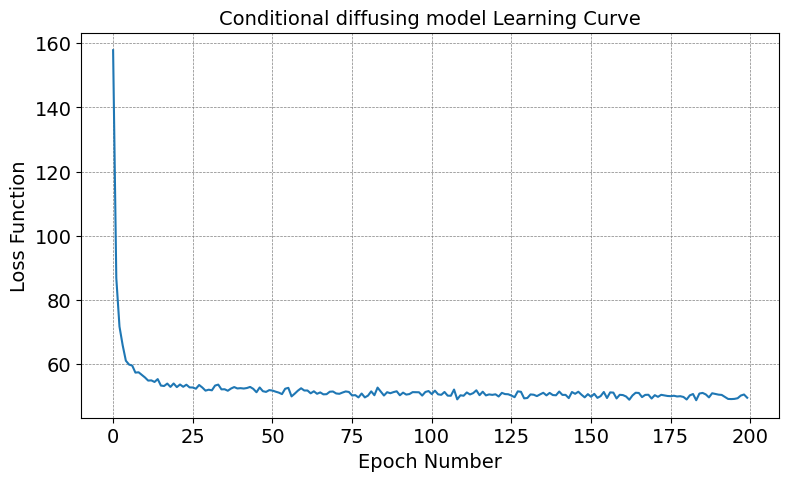

In [265]:
# diffusion learning curve
loss_hist = torch.tensor(diffusionFitter.loss_history).detach().numpy()
plt.figure(figsize=(9, 5))
plt.plot(loss_hist)
plt.xlabel("Epoch Number", size=14)
plt.ylabel("Loss Function", size=14)
plt.xticks(size=14)
plt.yticks(size=14)
plt.title("Conditional diffusing model Learning Curve", size=14)
plt.grid(b=1, linestyle="--", linewidth=0.5, color="0.5")
plt.show()

## Задание 14 (0.5 балла)
По аналогии с прошлым экспериментом с GAN моделью сгенерируйте выборку фейковых объектов равную размеру тестовой выборки и обучите градиентный бустинг. Обучите модель отличать реальные объекты от фейковых, после чего расчитайте метрики ROC-AUC и accuracy score. Какие получились результаты? Как вы их оцениваете? А в сравнении с GAN моделью?

In [266]:
generate_with_diffusion(model, y_test, latent_dim,noise_scheduler)


tensor([[-1.3070,  1.0918, -1.0122,  ..., -0.9606, -0.1161,  0.1435],
        [ 0.0370, -0.3664,  1.8824,  ..., -0.7210,  0.0097, -1.3902],
        [ 0.5980, -0.6070,  0.1732,  ..., -0.4422, -0.7258, -0.8075],
        ...,
        [-1.0228, -0.1124, -0.7959,  ..., -1.4367,  0.8431,  0.1937],
        [-1.0071,  0.1244, -0.6684,  ..., -0.1736, -2.2896, -0.7567],
        [ 1.1077,  0.8478, -1.2047,  ...,  1.0625,  0.8034,  2.2349]],
       grad_fn=<AddBackward0>)

In [267]:
X_fake_train = generate_with_diffusion(model, y_train, latent_dim, noise_scheduler)
X_fake_train = X_fake_train.detach().numpy()
X_fake_train = qt.inverse_transform(X_fake_train)
X_train_wo_qt = qt.inverse_transform(X_train)

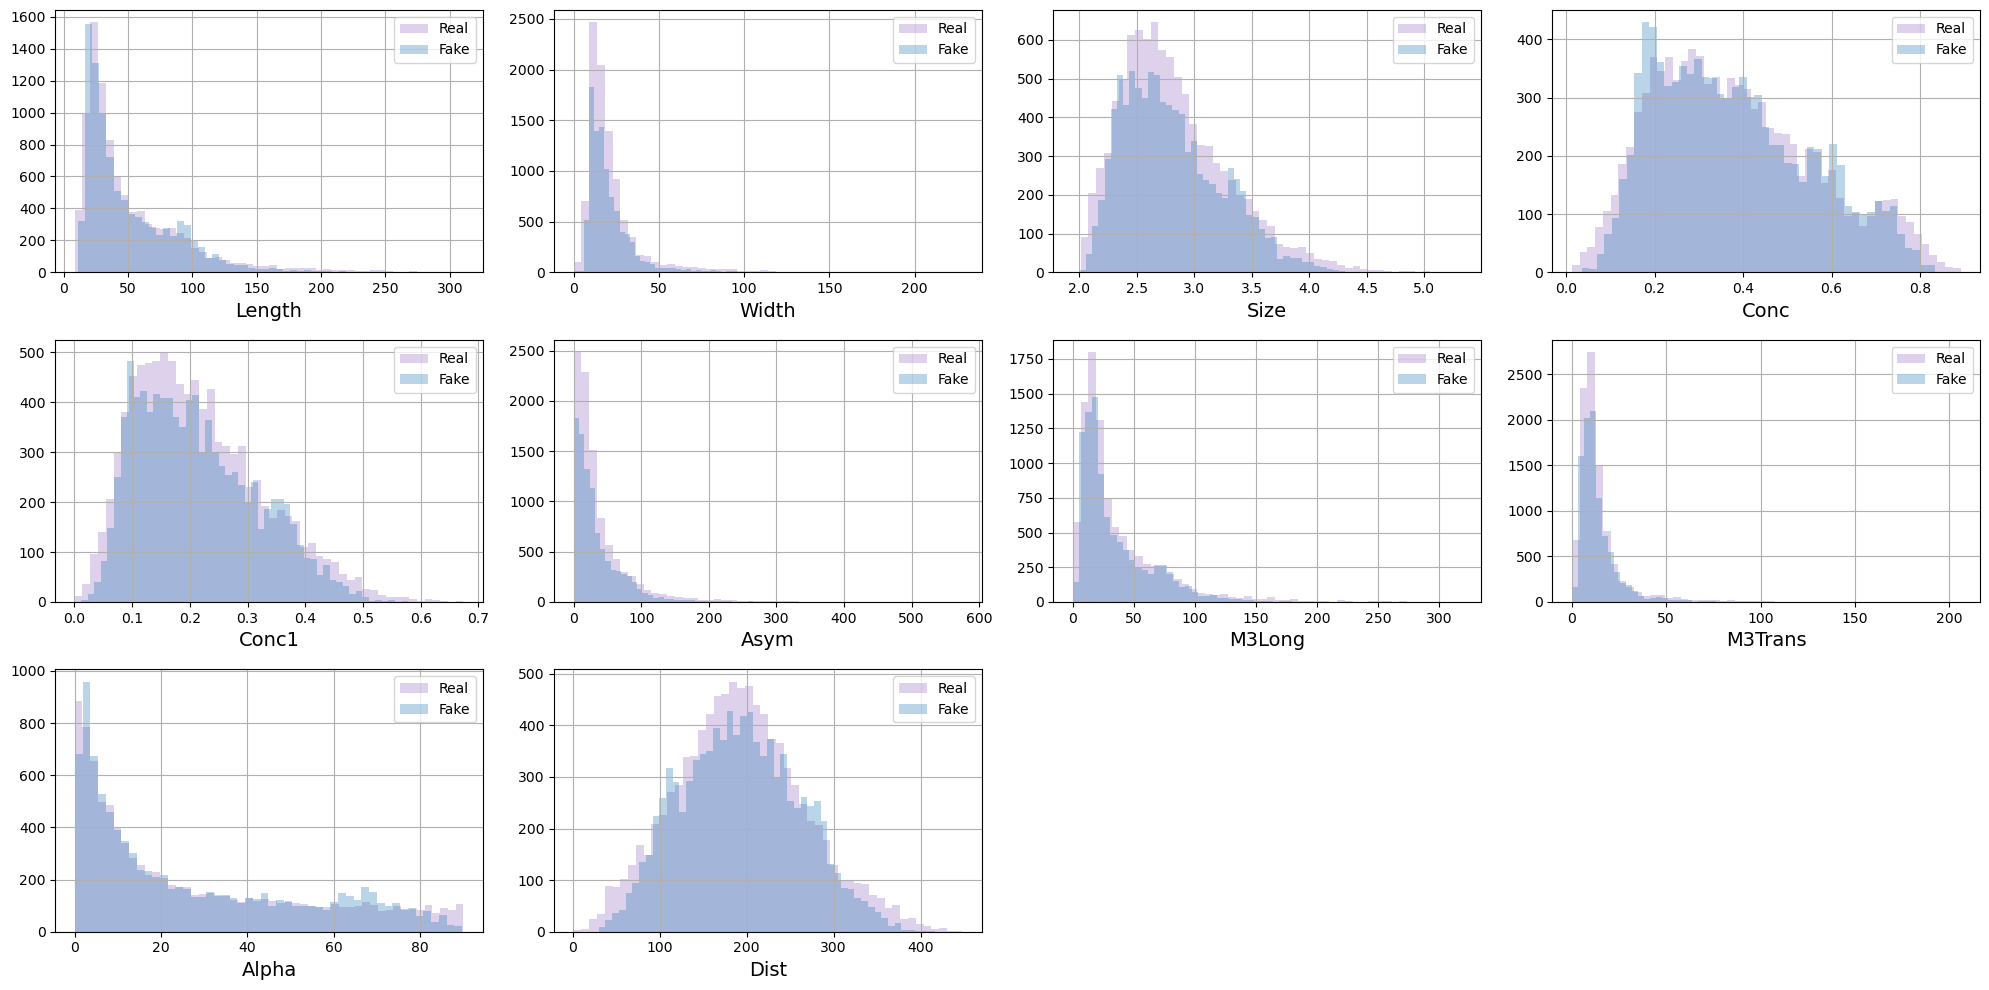

In [268]:
plot_hists(X_train_wo_qt, X_fake_train, names, label1="Real", label2="Fake", bins=50)

In [269]:
X_fake_test = generate_with_diffusion(model, y_test, latent_dim, noise_scheduler)
X_fake_test = X_fake_test.detach().numpy()
X_fake_test = qt.inverse_transform(X_fake_test)
X_test_wo_qt = qt.inverse_transform(X_test)


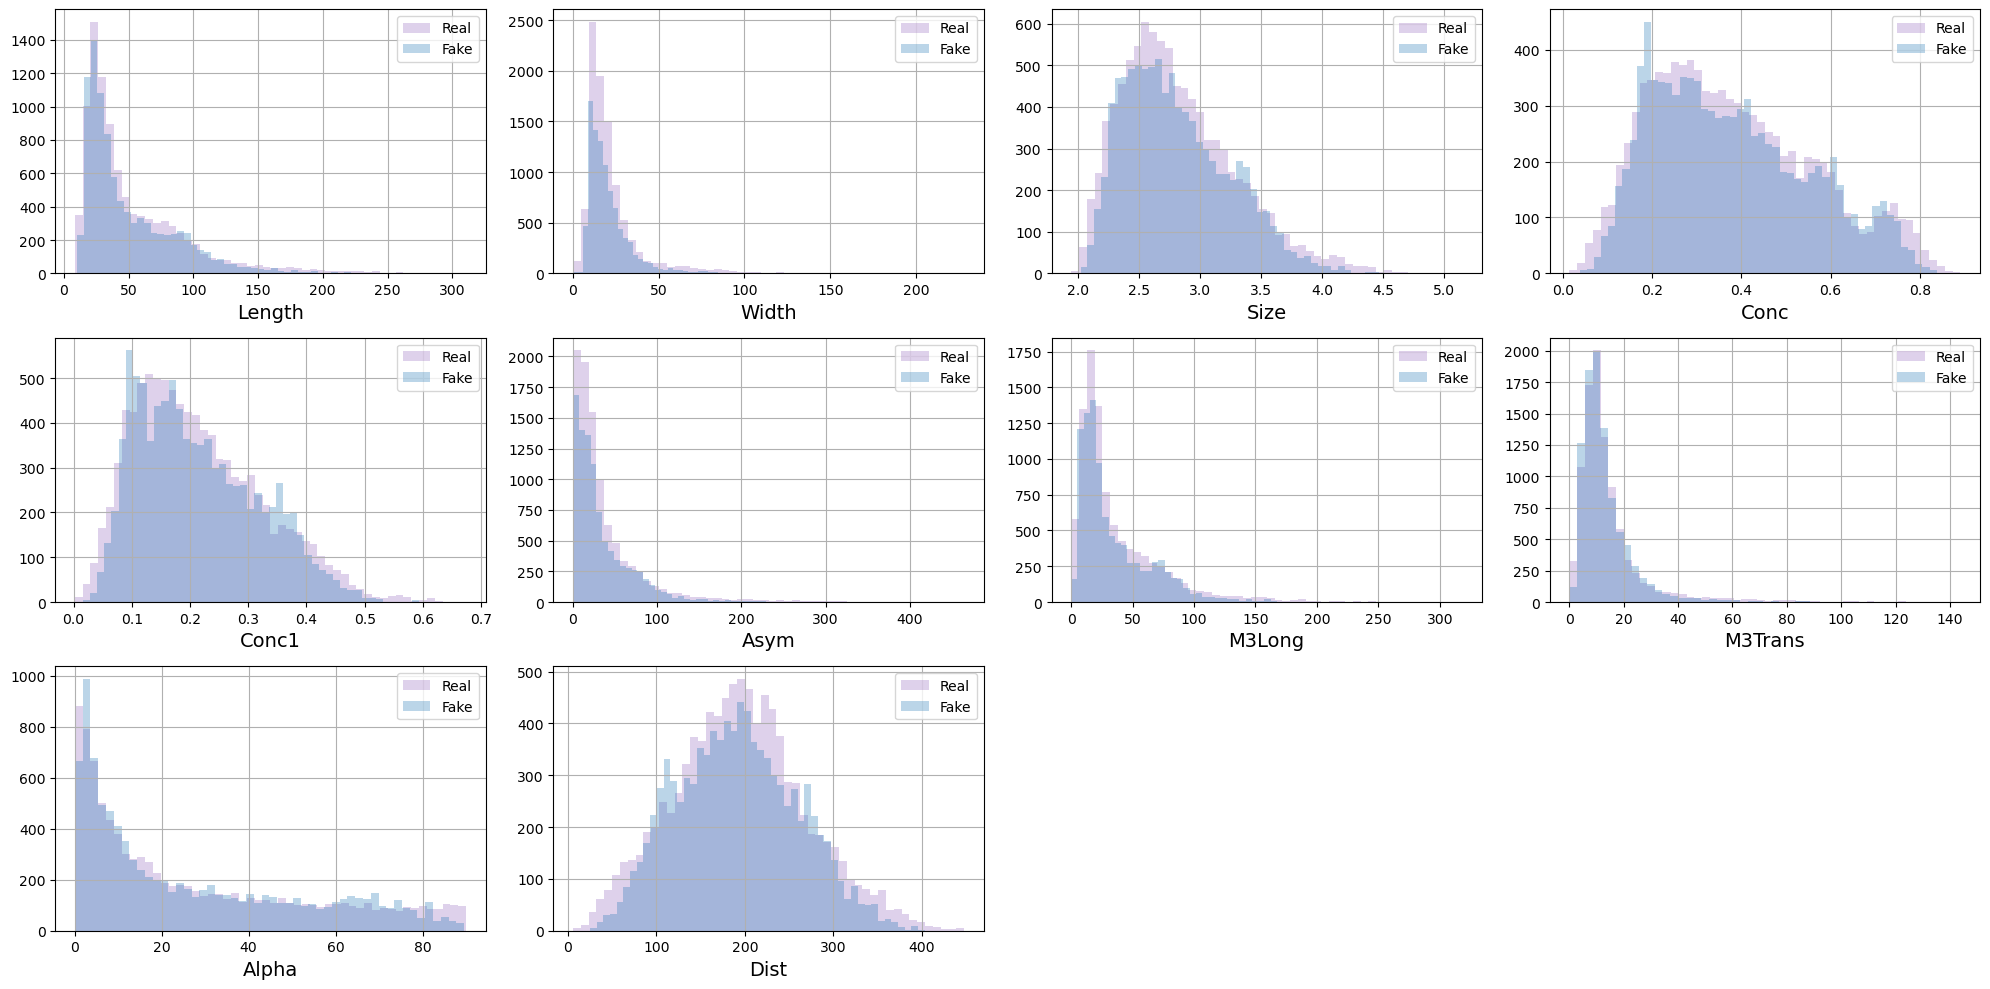

In [270]:

plot_hists(X_test_wo_qt, X_fake_test, names, label1="Real", label2="Fake", bins=50)

In [271]:
XX_train = np.concatenate((X_fake_train, X_train_wo_qt), axis=0)
XX_test = np.concatenate((X_fake_test, X_test_wo_qt), axis=0)

yy_train = np.array([0] * len(X_fake_train) + [1] * len(X_train_wo_qt))
yy_test = np.array([0] * len(X_fake_test) + [1] * len(X_test_wo_qt))

In [272]:
from sklearn.ensemble import GradientBoostingClassifier

# обучаем классификатор
clf = GradientBoostingClassifier()
clf.fit(XX_train, yy_train)

# получаем прогнозы
yy_test_proba = clf.predict_proba(XX_test)[:, 1]

In [273]:
from sklearn.metrics import roc_auc_score

auc = roc_auc_score(yy_test, yy_test_proba)
yy_test_proba1 = (torch.tensor(np.round(yy_test_proba), dtype=bool))
yy_test1 = torch.tensor(yy_test, dtype = bool)
acc = accuracy_score(yy_test1, yy_test_proba1)
print("acc =", acc)
print("ROC AUC = ", auc)

acc = 0.922502628811777
ROC AUC =  0.9788869539065083


ROC AUC и accuracy получились плохими, но судя по графикам сверху я был на относительно правильном пути. у Gan результат получился заметно лучше, но если бы я раньше начал делать работу и побольше бы посидел над 2 часть, дефузионная модель могла бы выдать результаты получше :)

## Отзыв

Поздравляю! Вы дошли до конца. Оставьте ваш отзыв ячейкой ниже или отправьте его в канал курса, нам будет очень интересно!